#3. Случайный лес (Random Forest)

Задание:

Внимание: два варианта работы

Построить модель для распознавания целевой переменной (отклика)

Использовать тот же набор данных, что и в первой лабораторной работе.

Для распознавания использовать Случайный лес (Random Forest)

Выбор критерия качества на Ваше усмотрение.

Обосновать выбор параметров модели.

Ожидается, что для подбора значений параметров будет использован GridSearch. Возможен выбор других стратегий подбора.


Ответ:

В данном задании была построена модель для распознавания целевой переменной (отклика) на основе Bank Marketing Data Set. Для распознавания использовался метод случайного леса (Random Forest). Критерием качества для данной выборки выбран Recall.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.shape

(45211, 17)

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
# Атрибут 'duration' сильно влияет на цель вывода (например, если duration=0, то y='no'),
# поэтому эти данные отбрасываем для получения реалистичной прогностической модели

df = df.loc[df['duration'] != 0]
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.shape

(45208, 17)

In [ ]:
# Проверим сбалансированность выборки

df['y'].value_counts() # выборка не сбалансированная, тк разница в 8 раз

no     39919
yes     5289
Name: y, dtype: int64

In [ ]:
df['y'].value_counts(normalize=True) # выборка не сбалансированная, тк разница в 8 раз

no     0.883007
yes    0.116993
Name: y, dtype: float64

In [ ]:
# Получим новый датафрейм только со значением y=yes

df_one = df.loc[df['y'] == 'yes']
df_one.shape

(5289, 17)

In [ ]:
# Получим новый датафрейм только со значением y=no и обновим индексы

df_y = df.loc[df['y'] == 'no']
df_y = df_y.reset_index(drop=True)
df_y.shape

(39919, 17)

In [ ]:
# Отделим первые 10578 строк значений в датафрейме только со значением y=no

df_two = df_y.loc[:10577]
df_two.shape

(10578, 17)

In [ ]:
# Создадим новый датафрейм, состоящий из двойного набора данных со значением отклика y=yes (5289*2=10578 строк)
# и набора данных со значением отклика y=no (10578 строк)

df_new = pd.concat([df_one, df_one, df_two], ignore_index=True)
df_new.shape

(21156, 17)

In [ ]:
# Проверим сбалансированность выборки нового датафрейма

df_new['y'].value_counts() # выборка сбалансирована

yes    10578
no     10578
Name: y, dtype: int64

In [ ]:
df_new['y'].value_counts(normalize=True) # выборка сбалансирована

yes    0.5
no     0.5
Name: y, dtype: float64

{0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid', 4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services', 8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'}


Text(0.5, 1.0, 'Распределение частотности классов в атрибуте job')

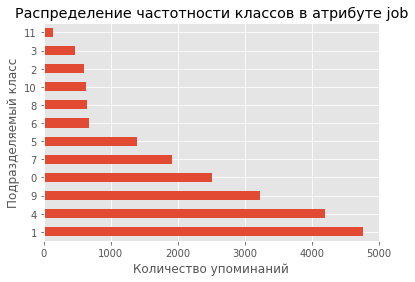

In [ ]:
# Заменим категориальные признаки на числовые во всем датафрейме

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
mapped_job = pd.Series(label_encoder.fit_transform(df_new['job']))

mapped_job.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

plt.xlabel('Количество упоминаний')
plt.ylabel('Подразделяемый класс')
plt.title('Распределение частотности классов в атрибуте job')

In [ ]:
categorical_columns = df_new.columns[df_new.dtypes == 'object'].union(['job'])
for column in categorical_columns:
    df_new[column] = label_encoder.fit_transform(df_new[column])
df_new.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


In [ ]:
df_new.shape

(21156, 17)

In [ ]:
# Преобразуем в столбцы с различными уникальными значениями, которые могут принимать категориальные столбцы исходной выборки

onehot_encoder = OneHotEncoder(sparse=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df_new[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
df.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45208.000000,45208,45208,45208,45208,45208.000000,45208,45208,45208,45208.000000,45208,45208.000000,45208.000000,45208.000000,45208.000000,45208,45208
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27211,23200,44393,NaN,25128,37965,29283,NaN,13764,NaN,NaN,NaN,NaN,36956,39919
mean,40.936294,NaN,NaN,NaN,NaN,1362.228676,NaN,NaN,NaN,15.806052,NaN,258.180211,2.763560,40.200562,0.580362,NaN,NaN
std,10.618823,NaN,NaN,NaN,NaN,3044.794660,NaN,NaN,NaN,8.322417,NaN,257.527769,3.097582,100.131506,2.303513,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [ ]:
#  Разделим предикторы и отклики

X = df_new.iloc[:, :-1]
y = df_new.iloc[:, 16] 

In [ ]:
#  Разделим на обучающую и тестовую выборку

from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)  

Стандартизация предикторов в данном случае, используя случайный лес (Random Forest), бессмысленна, поэтому этот шаг опускаем

In [ ]:
# Этот блок кода предназначен для проверки:
# отдельно применили стандартизацию предикторов, после чего результаты действительно нисколько не поменялись
 
# Стандартизация предикторов

#from sklearn.preprocessing import StandardScaler 

#scaler = StandardScaler()   #   среднее 0, ст.отклонение 1
#scaler.fit(X_train)

#  Одинаковые параметры стандартизации у обучающего и тестового множества

#X_train_2 = scaler.transform(X_train)  
#X_test_2 = scaler.transform(X_test)

In [ ]:
# Ручной подбор внешних параметров

from sklearn.ensemble import RandomForestClassifier

# Инициализируем модель

model = RandomForestClassifier(random_state=42,                             
                               n_estimators=80,              # число деревьев в лесу                             
                               criterion='gini',             # функция для impurity ('gini' или 'entropy')                             
                               max_depth=5,                  # максимальное число слоев                              
                               max_features='auto',          # автоматически применяется sqrt(k)                            
                               max_leaf_nodes=None,          # максимальное число конечных узлов
                               min_impurity_decrease=0.001,  # минимальное уменьшение загрязнения узла                             
                               bootstrap=True,               # подмножества обучающего множества с повторением                              
                               min_samples_leaf=10,          # минимальное число наблюдений в узле потомке                       
                               min_samples_split=15,         # минимальное число наблюдений в узле родителей                           
                               min_weight_fraction_leaf=0.0) # веса для классов                        

max_samples = 0.66     # доля наблюдений для построения очередного дерева
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_impurity_decrease=0.001,
                       min_samples_leaf=10, min_samples_split=15,
                       n_estimators=80, random_state=42)

In [ ]:
# Распознаю классы с помощью модели

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
#  Считаю recall модели

from sklearn.metrics import recall_score

print('Recall на обучающем множестве ', recall_score(y_train, y_pred_train)*100)
print('Recall на тестовом множестве ', recall_score(y_test, y_pred_test)*100)

Recall на обучающем множестве  90.7229596159277
Recall на тестовом множестве  90.81807780320365


In [ ]:
# Посчитаем precision, recall и f1-score

from sklearn import metrics

print(metrics.classification_report(y_test,  y_pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3486
           1       1.00      0.91      0.95      3496

    accuracy                           0.95      6982
   macro avg       0.96      0.95      0.95      6982
weighted avg       0.96      0.95      0.95      6982



In [ ]:
#   Информативность переменных

pd.DataFrame({'feature': X_train.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
8,contact,0.504878
10,month,0.204289
11,duration,0.084246
13,pdays,0.071984
14,previous,0.057598
6,housing,0.031705
15,poutcome,0.028278
0,age,0.007434
1,job,0.004084
3,education,0.002095


In [ ]:
#   Таблица сопряженности.  Обучающее множество

print(u'Таблица сопряженности для обучающей выборки')
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

Таблица сопряженности для обучающей выборки


,0,1
0,7092,0
1,657,6425


In [ ]:
#   Таблица сопряженности.  Тестовое множество

print(u'Таблица сопряженности для тестовой выборки')
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

Таблица сопряженности для тестовой выборки


,0,1
0,3486,0
1,321,3175


In [ ]:
#  С помощью модели оцениваем вероятности принадлежать классам 

y_pred_train2 = model.predict_proba(X_train)
y_pred_test2 = model.predict_proba(X_test)

In [ ]:
print(y_pred_train2)
print(y_pred_test2)

[[1.23466059e-02 9.87653394e-01]
 [5.09273715e-02 9.49072629e-01]
 [2.22665848e-03 9.97773342e-01]
 ...
 [6.99356913e-04 9.99300643e-01]
 [8.81842471e-01 1.18157529e-01]
 [0.00000000e+00 1.00000000e+00]]
[[0.93433083 0.06566917]
 [0.89663648 0.10336352]
 [0.92848451 0.07151549]
 ...
 [0.93476469 0.06523531]
 [0.04522286 0.95477714]
 [0.92759622 0.07240378]]


In [ ]:
# Подбор внешних параметров с помощью GridSearch

from sklearn.model_selection import GridSearchCV

model2 = RandomForestClassifier(random_state=42,                            
                               n_estimators=80,               # число деревьев в лесу                              
                               criterion='gini',              # функция для impurity ('gini' или 'entropy')                        
                               max_depth=5,                         
                               max_features='auto',           # sqrt(k)                            
                               max_leaf_nodes=None,           # максимальное число конечных узлов. сейчас - без ограничений                           
                               min_impurity_decrease=0.001,   # минимальное уменьшение загрязнения                        
                               bootstrap=True,                             
                               min_samples_leaf=10,           # минимальное число наблюдений в узле потомке                       
                               min_samples_split=15,          # минимальное число наблюдений в узле родителей                        
                               min_weight_fraction_leaf=0.0,                   
                               verbose=0,                     # объем промежуточных результатов в ходе обучения                          
                               oob_score=True,                # вычислять out-of-bag ошибку                   
                               warm_start=False,              # использовать результаты предыдущего вызова и нарастить предыдущий лес              
                               class_weight=None)             # веса классов для балансировки обучения

param_grid = {  
    'n_estimators': [40, 60, 80, 100],
    'max_depth': [4, 6, 8],
    'max_features': [3, 6, 10],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [4, 6, 8]}

grid_search_res = GridSearchCV(model2, param_grid=param_grid, cv=2,   # 2 фолда                        
                               scoring='recall',                      # выбор критерия качества    
                               error_score='raise',                   # поведение в случае ошибки при вычислении критерия качества                   
                               refit=True,                            # обучить модель с лучшими значениями параметроы
                               pre_dispatch=None, 
                               verbose=0)

grid_search_res.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
             estimator=RandomForestClassifier(max_depth=5,
                                              min_impurity_decrease=0.001,
                                              min_samples_leaf=10,
                                              min_samples_split=15,
                                              n_estimators=80, oob_score=True,
                                              random_state=42),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [3, 6, 10],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [40, 60, 80, 100]},
             pre_dispatch=None, scoring='recall')

In [ ]:
#   Лучший набор значений гиперпараметров

best_hyperparams = grid_search_res.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 100}


In [ ]:
# Значение критерия качества для лучших значений гиперпараметров 

best_CV_score = grid_search_res.best_score_
print('Лучший recall', best_CV_score)

Лучший recall 0.9584863033041514


In [ ]:
# Лучшая модель
best_model = grid_search_res.best_estimator_

# recall на тестовом множестве для лучшей модели
test_recall = best_model.score(X_test,y_test)

# Значение критерия качества для лучших значений гиперпараметров 
print('Лучший recall на тестовом множестве', test_recall)

Лучший recall на тестовом множестве 0.9674878258378689


In [ ]:
grid_search_res.cv_results_

{'mean_fit_time': array([0.20206618, 0.28334916, 0.37203276, 0.45839047, 0.18443561,
        0.27629721, 0.36912858, 0.46379161, 0.19330096, 0.27787256,
        0.37653387, 0.47195363, 0.18535233, 0.2757051 , 0.36572611,
        0.46453881, 0.19129014, 0.26805913, 0.36294997, 0.45068717,
        0.1834687 , 0.26940787, 0.36032546, 0.46364796, 0.18230629,
        0.27573252, 0.35549021, 0.44995809, 0.18592894, 0.27536476,
        0.36402559, 0.44001245, 0.18601942, 0.27828062, 0.36380792,
        0.46687627, 0.23804891, 0.33810163, 0.44876063, 0.59521174,
        0.23323894, 0.34154916, 0.45961547, 0.56036246, 0.22259641,
        0.33557749, 0.45722556, 0.57340169, 0.22598875, 0.33802259,
        0.45016897, 0.54761803, 0.22670245, 0.34310365, 0.45126891,
        0.56536412, 0.24181616, 0.34320319, 0.46039212, 0.55740404,
        0.2305938 , 0.33957469, 0.44980049, 0.56614077, 0.22817469,
        0.3451165 , 0.44134712, 0.53752506, 0.21750379, 0.32864821,
        0.44074285, 0.53529453,

In [ ]:
means = grid_search_res.cv_results_['mean_test_score']
stds  = grid_search_res.cv_results_['std_test_score']

In [ ]:
for mean, std, params in zip(means, stds, grid_search_res.cv_results_['params']):
    print("%0.4f (+/-%0.03f) for %r"  % (mean, std * 2, params))
print()

0.9034 (+/-0.003) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 40}
0.9047 (+/-0.004) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 60}
0.9044 (+/-0.003) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 80}
0.9047 (+/-0.004) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 100}
0.9034 (+/-0.003) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 40}
0.9047 (+/-0.004) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 60}
0.9044 (+/-0.003) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80}
0.9047 (+/-0.004) for {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100

In [ ]:
# Строим предсказание модели

y_pred_train = grid_search_res.predict(X_train)
y_pred_test = grid_search_res.predict(X_test)

In [ ]:
# Таблица сопряженности. Обучающее множество

print(u'Таблица сопряженности для обучающей выборки')
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

Таблица сопряженности для обучающей выборки


,0,1
0,6954,138
1,288,6794


In [ ]:
# Таблица сопряженности. Тестовое множество

print(u'Таблица сопряженности для тестовой выборки')
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

Таблица сопряженности для тестовой выборки


,0,1
0,3421,65
1,162,3334


In [ ]:
# Строим предсказание модели

y_pred_train2 = grid_search_res.predict_proba(X_train)
y_pred_test2 = grid_search_res.predict_proba(X_test)
print(y_pred_train2)
print(y_pred_test2)

[[0.        1.       ]
 [0.        1.       ]
 [0.        1.       ]
 ...
 [0.        1.       ]
 [0.9777889 0.0222111]
 [0.        1.       ]]
[[0.98392794 0.01607206]
 [0.98244004 0.01755996]
 [0.98392794 0.01607206]
 ...
 [0.98392794 0.01607206]
 [0.         1.        ]
 [0.98392794 0.01607206]]


In [ ]:
# Посчитаем precision, recall и f1-score

y_pred_train2 = grid_search_res.predict(X_train)
y_pred_test2 = grid_search_res.predict(X_test)
print(metrics.classification_report(y_pred_test2, y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3583
           1       0.95      0.98      0.97      3399

    accuracy                           0.97      6982
   macro avg       0.97      0.97      0.97      6982
weighted avg       0.97      0.97      0.97      6982

